In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

### Data

In [2]:
features, labels = make_moons(n_samples=5000, random_state=42, noise=0.1)

In [3]:
features.shape, labels.shape

((5000, 2), (5000,))

In [4]:
features[:5]

array([[-0.1196884 ,  1.03684845],
       [ 0.03370055,  0.2493631 ],
       [ 0.03864294,  0.33033539],
       [ 0.22222051,  1.03355193],
       [ 0.74448612,  0.69288687]])

In [5]:
labels[:5]

array([0, 1, 1, 0, 0])

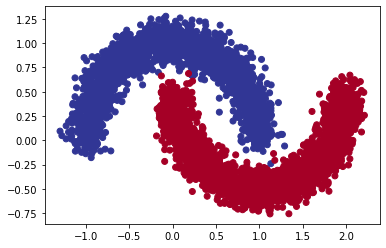

In [6]:
plt.scatter(features[:,0], features[:,1], c = labels, cmap = plt.cm.RdYlBu_r)

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.82156273  0.69359228]
 [-1.03412448  0.12692978]
 [ 0.59252443  0.83259841]
 [-0.76407333  0.734864  ]
 [ 1.62956144 -0.24776833]
 [-0.66003888  0.68920875]
 [ 1.44300705 -0.45161169]
 [ 0.25034191  0.85125538]
 [ 0.13190513 -0.12026428]
 [ 0.20386009  0.81014625]], shape=(10, 2), dtype=float64) 
 tf.Tensor([0 0 0 0 1 0 1 0 1 0], shape=(10,), dtype=int64)


### Initializing Model Parameters

In [9]:
num_inputs = 2
num_outputs = 2
num_hiddens = 200

W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_hiddens], stddev=.01))
W3 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b3 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2, W3, b3]

### Softmax Activation

In [10]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

### ReLU Activation

In [11]:
def relu(X):
    return tf.math.maximum(X, 0)

### Defining the Model

In [12]:
def net(X):
    X = tf.reshape(tf.cast(X, dtype=tf.float32), (-1, num_inputs))
    H1 = relu(tf.matmul(X, W1) + b1)
    H2 = relu(tf.matmul(H1, W2) + b2)
    return softmax(tf.matmul(H2, W3) + b3)

### Loss Function

In [13]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### Optimization

#### The Momentum Method

If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

$\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}$

In [14]:
def init_momentum_states():
    v_W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
    v_b1 = tf.Variable(tf.zeros(num_hiddens))
    v_W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=0.01))
    v_b2 = tf.Variable(tf.random.normal([num_hiddens], stddev=.01))
    v_W3 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
    v_b3 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))
    return (v_W1, v_b1, v_W2, v_b2, v_W3, v_b3)

In [15]:
def sgd_momentum(params, grads, states, lr, momentum):
    for p, v, g in zip(params, states, grads):
        v[:].assign(momentum * v + g)
        p[:].assign(p - lr * v)

### Training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [17]:
X_train.shape, X_test.shape

((3750, 2), (1250, 2))

In [18]:
num_epochs = 10
states = init_momentum_states()
lr = 0.1
momentum = 0.5
loss = cross_entropy

In [19]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, X_train, y_train):
      with tf.GradientTape() as g:
        l = tf.math.reduce_mean(loss(net(X), y))

      grads = g.gradient(l, params)
      sgd_momentum(params, grads, states, lr, momentum)

### Decision Boundary

In [20]:
def plot_decision_boundary(net, X, y):
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    # Make predictions using the trained model
    y_pred = np.array(net(x_in)).argmax(axis=1)
    # Check for multi-class
    if y_pred[0].size > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

doing binary classifcation...


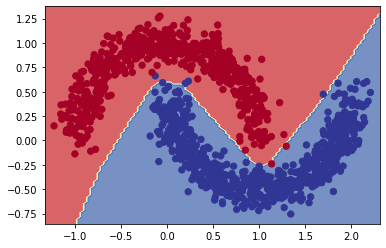

In [21]:
plot_decision_boundary(net, X_test, y_test)